In [30]:
### 1. Setup
# 1.1 Import Dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics import precision_score, recall_score
import uuid

In [31]:
# 1.2 Thiết lập các đường dẫn thư mục
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# Tạo các thư mục nếu chưa tồn tại
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [3]:
## 2. Collect Positives and Anchors
# 2.1 Move LFW images to the following repository data/negative
for directory in os.listdir('lfw-deepfunneled'):
    for file in os.listdir(os.path.join('lfw-deepfunneled', directory)):
        EX_PATH = os.path.join('lfw-deepfunneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [10]:
# 2.2 Collect Positive and Anchor Classes

import uuid # To creat unique names for images

cap = cv2.VideoCapture(0)  # Có thể cần điều chỉnh index camera
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Cắt khung ảnh thành 250x250px
    frame = frame[120:120+250, 200:200+250, :]

    # Thu thập ảnh anchor khi nhấn phím 'a'
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Thu thập ảnh positive khi nhấn phím 'p'
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Hiển thị khung ảnh
    cv2.imshow('Image Collection', frame)

    # Thoát khi nhấn 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [27]:
# 2.3 Data Augmentation

# Hàm tăng cường dữ liệu
def data_aug(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
        transforms.ToTensor()
    ])
    return [transform(img) for _ in range(2)]  # Tạo 2 ảnh tăng cường mỗi ảnh gốc


# Hàm tăng cường dữ liệu cho một thư mục
def augment_directory(input_path, target_count=3000):
    # Lấy danh sách các file ảnh trong thư mục
    img_files = [f for f in os.listdir(input_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(img_files)
    
    if current_count == 0:
        print(f"Không tìm thấy ảnh trong thư mục: {input_path}")
        return
    
    # Tính số ảnh cần tăng cường
    images_to_generate = target_count - current_count  # 3000 - 1000 = 2000
    images_per_original = 4  # Mỗi ảnh gốc tạo 2 ảnh tăng cường
    
    if images_to_generate <= 0:
        print(f"Thư mục {input_path} đã có đủ hoặc vượt quá {target_count} ảnh")
        return
    
    print(f"Bắt đầu tăng cường dữ liệu cho {input_path}...")
    print(f"Hiện có {current_count} ảnh, cần tạo thêm {images_to_generate} ảnh")
    
    # Lặp qua các ảnh gốc
    generated_count = 0
    for img_name in img_files:
        img_path = os.path.join(input_path, img_name)
        
        # Đọc và tiền xử lý ảnh
        img = cv2.imread(img_path)
        if img is None:
            print(f"Không thể đọc ảnh: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
        
        # Tạo ảnh tăng cường
        augmented_images = data_aug(img)
        
        # Lưu các ảnh tăng cường
        for aug_img in augmented_images:
            if generated_count >= images_to_generate:
                break  # Đã tạo đủ số ảnh cần thiết
            aug_img = aug_img.permute(1, 2, 0).numpy() * 255  # Chuyển về định dạng numpy
            aug_img = aug_img.astype(np.uint8)
            # Lưu vào cùng thư mục với tên duy nhất
            aug_img_path = os.path.join(input_path, f'aug_{uuid.uuid1()}.jpg')
            cv2.imwrite(aug_img_path, aug_img)
            generated_count += 1
            print(f"Đã lưu ảnh tăng cường: {aug_img_path}")
        
        if generated_count >= images_to_generate:
            break  # Thoát vòng lặp nếu đã đủ ảnh
    
    print(f"Hoàn tất tăng cường dữ liệu cho {input_path}. Tổng số ảnh hiện tại: {len(os.listdir(input_path))}")

# Tăng cường dữ liệu cho cả hai thư mục
augment_directory(ANC_PATH, target_count=3000)
augment_directory(POS_PATH, target_count=3000)

Bắt đầu tăng cường dữ liệu cho data\anchor...
Hiện có 2160 ảnh, cần tạo thêm 840 ảnh
Đã lưu ảnh tăng cường: data\anchor\aug_8fa8e7c6-1f57-11f0-9d28-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fab6e59-1f57-11f0-ac8c-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fb3092c-1f57-11f0-a9f0-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fb49166-1f57-11f0-a2fb-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fb9164c-1f57-11f0-8da9-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fbac665-1f57-11f0-9480-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fc11910-1f57-11f0-ad6b-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fc28ccb-1f57-11f0-bab6-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fc6dc59-1f57-11f0-848e-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fc7dbfb-1f57-11f0-9067-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\aug_8fcc74ba-1f57-11f0-8f95-70a8d31dd8ec.jpg
Đã lưu ảnh tăng cường: data\anchor\

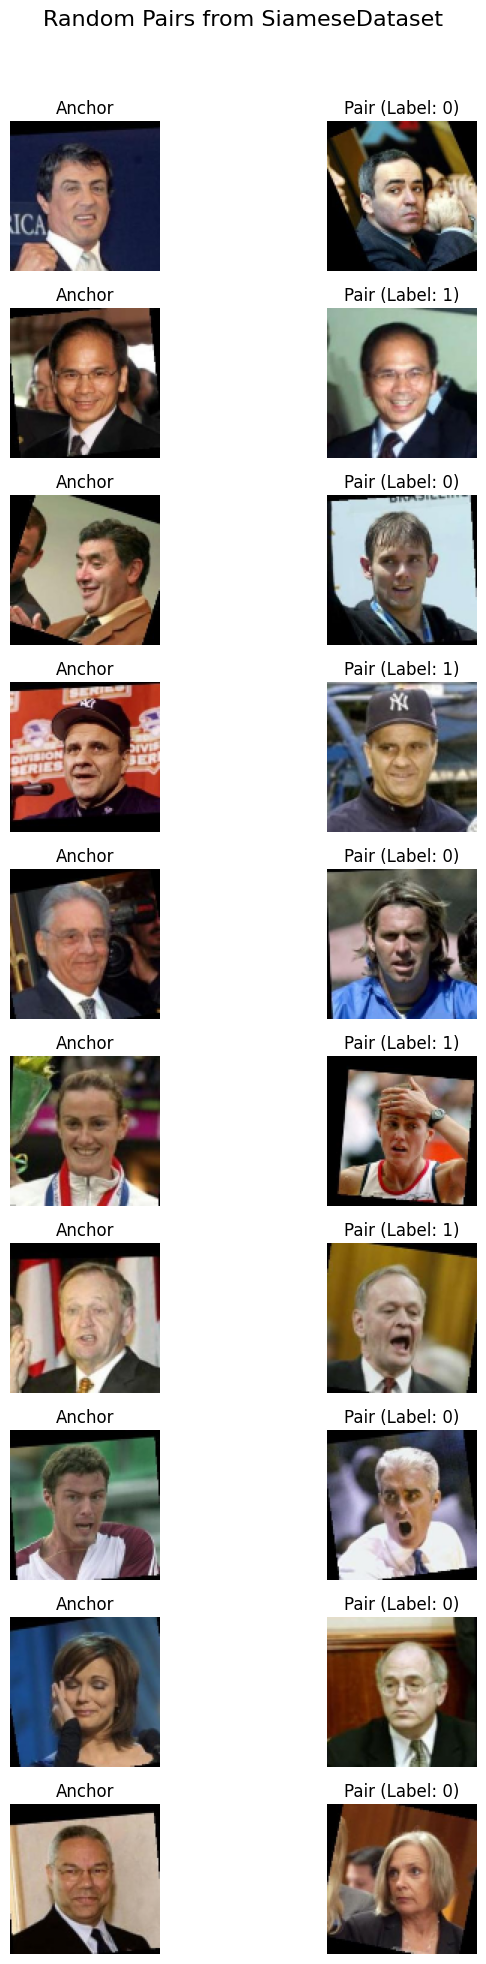

Số lượng mini-batches: 412
Kích thước của tập train: 6582
Kích thước của tập dataset: 9404


In [33]:
## 3. Loading and Processing the Data
from glob import glob
import random
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 3.1 Group Images by Person and Create Pairs
def create_lfw_pairs(lfw_path, max_pairs_per_person=5):
    """
    Nhóm ảnh theo người và tạo cặp positive/negative từ tập LFW.
    Args:
        lfw_path: Đường dẫn đến thư mục chứa ảnh LFW (data/negative).
        max_pairs_per_person: Số cặp positive tối đa cho mỗi người.
    Returns:
        positive_pairs: List các tuple (anchor_path, positive_path, 1).
        negative_pairs: List các tuple (anchor_path, negative_path, 0).
    """
    # Nhóm ảnh theo người
    people = defaultdict(list)
    for filename in os.listdir(lfw_path):
        if filename.endswith('.jpg'):
            person_name = '_'.join(filename.split('_')[:-1])  # Lấy tên người
            people[person_name].append(os.path.join(lfw_path, filename))

    positive_pairs = []
    negative_pairs = []
    all_people = list(people.keys())

    # Tạo cặp positive
    for person, images in people.items():
        if len(images) >= 2:  # Chỉ lấy người có ít nhất 2 ảnh
            # Tạo tất cả cặp có thể, nhưng giới hạn số lượng
            pairs = [(images[i], images[j], 1) for i in range(len(images))
                     for j in range(i + 1, len(images))]
            if len(pairs) > max_pairs_per_person:
                pairs = random.sample(pairs, max_pairs_per_person)
            positive_pairs.extend(pairs)

    # Tạo cặp negative
    for person, images in people.items():
        for anchor in images:
            # Chọn ngẫu nhiên một người khác
            other_person = random.choice(all_people)
            while other_person == person:
                other_person = random.choice(all_people)
            negative_image = random.choice(people[other_person])
            negative_pairs.append((anchor, negative_image, 0))

    # Cân bằng số lượng cặp
    num_positive = len(positive_pairs)
    negative_pairs = random.sample(negative_pairs, num_positive)

    return positive_pairs, negative_pairs

# Đường dẫn đến thư mục LFW (nơi chứa ảnh negative)
lfw_path = NEG_PATH  # data/negative
positive_pairs, negative_pairs = create_lfw_pairs(lfw_path, max_pairs_per_person=5)

# Kết hợp và xáo trộn dữ liệu
dataset_pairs = positive_pairs + negative_pairs
random.shuffle(dataset_pairs)

# 3.2 Preprocessing - Scale and Resize
def preprocess(file_path):
    """
    Tiền xử lý ảnh: đọc, chuyển RGB, resize, scale.
    """
    img = cv2.imread(file_path)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh: {file_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100))
    img = img / 255.0  # Scale to [0, 1]
    return img

# 3.3 Create Labelled Dataset
class SiameseDataset(Dataset):
    """
    Dataset cho mô hình Siamese, sử dụng danh sách cặp (anchor, pair, label).
    """
    def __init__(self, pairs):
        self.pairs = pairs
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
        anchor_path, pair_path, label = self.pairs[index]
        anchor = preprocess(anchor_path)
        pair = preprocess(pair_path)
        return (torch.tensor(anchor, dtype=torch.float32).permute(2, 0, 1),  # [C, H, W]
                torch.tensor(pair, dtype=torch.float32).permute(2, 0, 1),
                torch.tensor(label, dtype=torch.float32))

# Tạo dataset
dataset = SiameseDataset(dataset_pairs)

# 3.4 Build Train and Test Partition
# Chia tập dữ liệu thành train và test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 3.5 Display Random Pairs
def display_random_pairs(dataset, num_pairs=10):
    """
    Hiển thị ngẫu nhiên các cặp ảnh từ dataset.
    """
    indices = random.sample(range(len(dataset)), num_pairs)
    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, num_pairs * 2))
    fig.suptitle('Random Pairs from SiameseDataset', fontsize=16)
    
    for i, idx in enumerate(indices):
        anchor, pair, label = dataset[idx]
        anchor_np = anchor.permute(1, 2, 0).numpy()
        pair_np = pair.permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(anchor_np)
        axes[i, 0].set_title('Anchor')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pair_np)
        axes[i, 1].set_title(f'Pair (Label: {label.item():.0f})')
        axes[i, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Gọi hàm để hiển thị 10 cặp ảnh ngẫu nhiên
display_random_pairs(train_dataset, num_pairs=10)

# In thông tin
print(f"Số lượng mini-batches: {len(train_loader)}")
print(f"Kích thước của tập train: {len(train_loader.dataset)}")
print(f"Kích thước của tập dataset: {len(dataset)}")
print(dataset)

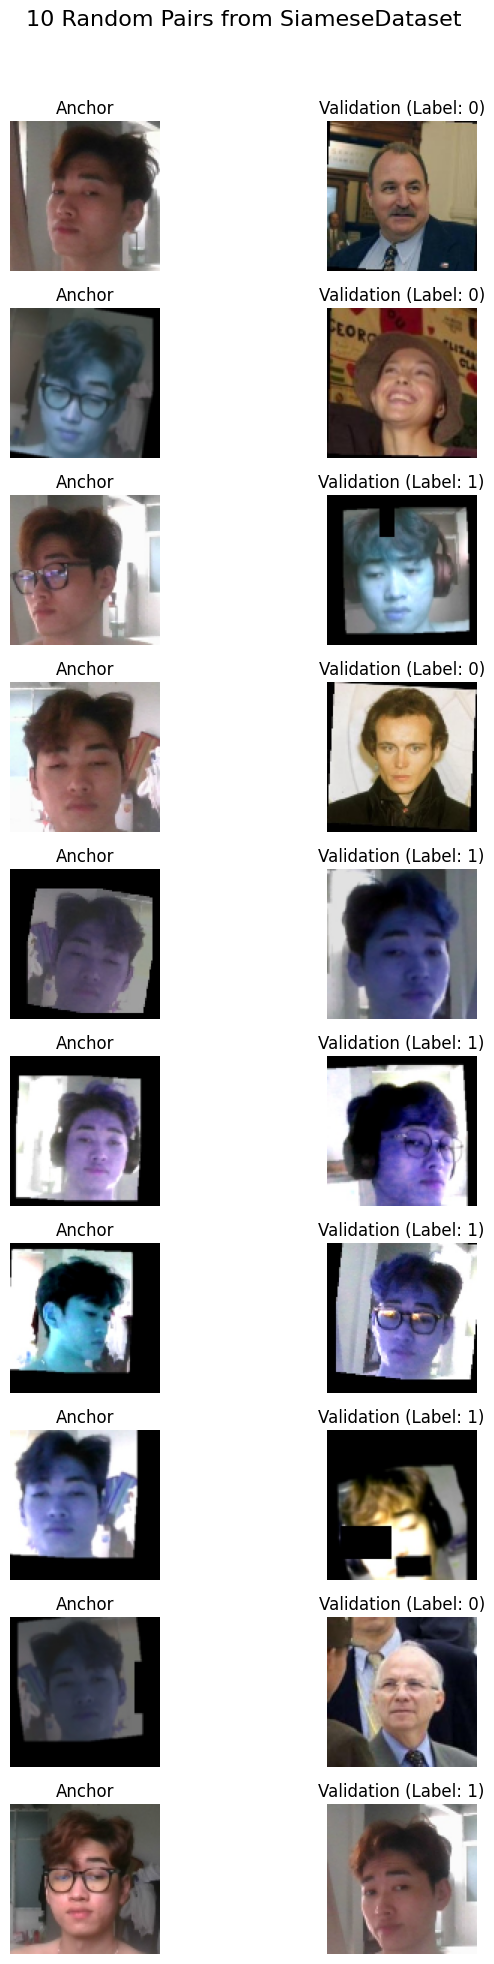

Số lượng mini-batches: 263
Kích thước của tập train: 4200
Kích thước của tập dataset: 6000


In [ ]:
# ## 3. Loading and Processing the Data
# from glob import glob
# import random

# # 3.1 Get Image Directories
# anchor_files = glob(os.path.join(ANC_PATH, '*.jpg'))[:3000]
# positive_files = glob(os.path.join(POS_PATH, '*.jpg'))[:3000]
# negative_files = glob(os.path.join(NEG_PATH, '*.jpg'))[:3000]


# # 3.2 Preprocessing - Scale and Resize
# def preprocess(file_path):
#     img = cv2.imread(file_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (100, 100))
#     img = img / 255.0 # Scale to [0, 1]
#     return img


# # 3.3 Create Labelled Dataset
# class SiameseDataset(Dataset):
#     def __init__(self, anchor_files, positive_files, negative_files):
#         self.anchor_files = anchor_files
#         self.positive_files = positive_files
#         self.negative_files = negative_files
    
#     def __len__(self):
#         return len(self.anchor_files) * 2
    
#     def __getitem__(self, index):
#         if index < len(self.anchor_files):
#             anchor = preprocess(self.anchor_files[index])
#             positive = preprocess(self.positive_files[index])
#             label = 1.0
#         else:
#             anchor = preprocess(self.anchor_files[index - len(self.anchor_files)])
#             negative = preprocess(self.negative_files[index - len(self.anchor_files)])
#             label = 0.0
#         return (torch.tensor(anchor, dtype=torch.float32).permute(2, 0, 1),  # Chuyển sang định dạng PyTorch
#                 torch.tensor(positive if label == 1.0 else negative, dtype=torch.float32).permute(2, 0, 1),
#                 torch.tensor(label, dtype=torch.float32))
    
# dataset = SiameseDataset(anchor_files, positive_files, negative_files)

# # print(dataset[300])
# # plt.imshow(dataset[300][0].permute(1,2,0).numpy())

# # 3.4 Build Train and Test Partition
# # Chia tập dữ liệu thành train và test
# train_size = int(0.7 * len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # Tạo DataLoader
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # In 10 cặp ảnh ngẫu nhiên
# def display_random_pairs(dataset, num_pairs=10):
#     # Lấy 10 chỉ số ngẫu nhiên
#     indices = random.sample(range(len(dataset)), num_pairs)
    
#     # Thiết lập lưới hiển thị (2 cột: anchor và validation, 10 hàng)
#     fig, axes = plt.subplots(num_pairs, 2, figsize=(8, num_pairs * 2))
#     fig.suptitle('10 Random Pairs from SiameseDataset', fontsize=16)
    
#     for i, idx in enumerate(indices):
#         # Lấy cặp ảnh và nhãn
#         anchor, val, label = dataset[idx]
        
#         # Chuyển tensor về numpy và định dạng RGB
#         anchor_np = anchor.permute(1, 2, 0).numpy()
#         val_np = val.permute(1, 2, 0).numpy()
        
#         # Hiển thị ảnh anchor
#         axes[i, 0].imshow(anchor_np)
#         axes[i, 0].set_title(f'Anchor')
#         axes[i, 0].axis('off')
        
#         # Hiển thị ảnh validation (positive hoặc negative)
#         axes[i, 1].imshow(val_np)
#         axes[i, 1].set_title(f'Validation (Label: {label.item():.0f})')
#         axes[i, 1].axis('off')
    
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

# # Gọi hàm để in 10 cặp ảnh ngẫu nhiên
# display_random_pairs(train_dataset, num_pairs=10)
    



# print(f"Số lượng mini-batches: {len(train_loader)}")
# print(f"Kích thước của tập train: {len(train_loader.dataset)}")
# print(f"Kích thước của tập dataset: {len(dataset)}")

In [ ]:
## 4. Model Engineering
# 4.1 Build Embedding Layer
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=10) 
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)  # Thêm ceil_mode=True làm cho kích thước đầu ra được làm tròn lên (ceil) thay vì làm tròn xuống (floor), tương tự với padding='same' trong TensorFlow.
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7)
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)  # Thêm dropout
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.dropout(x)  # Áp dụng dropout
        x = self.sigmoid(self.fc1(x))
        return x

embedding_net = EmbeddingNet()

# 4.2 Build Distance Layer L1
class L1Dist(nn.Module):
    def __init__(self):
        super(L1Dist, self).__init__()
    
    def forward(self, input_embedding, validation_embedding):
        return torch.abs(input_embedding - validation_embedding)  # Trả về vector chênh lệch tuyệt đối giữa 2 embedding

# 4.3 Make Siamese Network 
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net
        self.L1_dist = L1Dist()
        self.fc = nn.Linear(4096, 1) # Fully connected layer to output a single value
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_img, validation_img):
        input_embedding = self.embedding_net(input_img)
        validation_embedding = self.embedding_net(validation_img)
        distances = self.L1_dist(input_embedding, validation_embedding)
        fully_connected = self.fc(distances)
        output = self.sigmoid(fully_connected)
        return output

siamese_model = SiameseNetwork(embedding_net)
print(siamese_model)

SiameseNetwork(
  (embedding_net): EmbeddingNet(
    (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (L1_dist): L1Dist()
  (fc): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
## 5. Training the Model

# 5.1 Establish Checkpoints
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 5.2 Build Training Loop 
def print_train_time(start, end):
    total_time = end - start
    print(f"Training Time: {total_time:.2f} seconds")
    return total_time

def train_model(model, train_dataloader, test_dataloader, epochs, learning_rate):
    torch.manual_seed(42)
    train_time_start_on_cpu = timer()    

    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\\n------------------------------")

        ### Training
        train_loss = 0
        train_labels = []
        train_preds = []

        for batch, (input_img, validation_img, label) in enumerate(train_dataloader):
            model.train()
            label = label.unsqueeze(1)  # Thêm chiều để khớp với output

            # 1. Forward pass
            output = model(input_img, validation_img)
            
            # 2. Calculate loss (per batch)
            loss = loss_fn(output, label)
            train_loss += loss.item()

            # 3. Accumulate predictions and labels for precision/recall
            # precision_score và recall_score yêu cầu đầu vào là mảng NumPy 1 chiều (flat array) và phải ở trên CPU
            pred = (output > 0.5).float().cpu().numpy() # True nếu giá trị > 0.5, False nếu không
            train_preds.extend(pred.flatten())
            train_labels.extend(label.cpu().numpy().flatten())

            # 4. Optimizer zero_grad
            optimizer.zero_grad()

            # 5. Loss backward
            loss.backward()

            # 6. Optimizer step
            optimizer.step()

            # In ra có bao nhiêu samples đã được train
            if batch % 400 == 0:
                print(f"Looked at {batch * 16}/{len(train_dataloader.dataset)} samples")

        train_loss /= len(train_dataloader)
        train_precision = precision_score(train_labels, train_preds, zero_division=0)
        train_recall = recall_score(train_labels, train_preds, zero_division=0)
        print(f"Train Loss: {train_loss:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")

        ### Testing
        test_loss = 0
        test_labels = []
        test_preds = []
        model.eval()
        with torch.inference_mode(): # Tắt gradient để tăng tốc độ
            for input_img, validation_img, label in test_dataloader:
                label = label.unsqueeze(1)  # Thêm chiều để khớp với output
                # 1. Forward pass
                test_output = model(input_img, validation_img)

                # 2. Calculate loss (accumulate)
                test_loss += loss_fn(test_output, label).item()

                # 3. Accumulate predictions and labels
                pred = (test_output > 0.5).float().cpu().numpy()
                test_preds.extend(pred.flatten())
                test_labels.extend(label.cpu().numpy().flatten())

        test_loss /= len(test_dataloader)
        test_precision = precision_score(test_labels, test_preds, zero_division=0)
        test_recall = recall_score(test_labels, test_preds, zero_division=0)
        print(f"Test Loss: {test_loss:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

        # Lưu checkpoint mỗi 10 epoch
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'test_loss': test_loss,
            }, os.path.join(checkpoint_dir, f'ckpt_epoch_{epoch + 1}.pt'))

    train_time_end_on_cpu = timer()
    print_train_time_model = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu)

# 5.4 Train the Model
train_model(siamese_model, train_loader, test_loader, epochs=50, learning_rate=0.0001)

Epoch 1\n------------------------------
Looked at 0/14000 samples
Looked at 6400/14000 samples


KeyboardInterrupt: 

In [ ]:
# # 6. Real Time Test
# import torch
# import torch.nn as nn
# import cv2
# import os
# import numpy as np

# # Định nghĩa mô hình (giữ nguyên từ code của bạn)
# class EmbeddingNet(nn.Module):
#     def __init__(self):
#         super(EmbeddingNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=10)
#         self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=7)
#         self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True)
#         self.conv3 = nn.Conv2d(128, 128, kernel_size=4)
#         self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=4)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(256 * 6 * 6, 4096)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.pool1(x)
#         x = self.relu(self.conv2(x))
#         x = self.pool2(x)
#         x = self.relu(self.conv3(x))
#         x = self.pool3(x)
#         x = self.relu(self.conv4(x))
#         x = self.flatten(x)
#         x = self.sigmoid(self.fc1(x))
#         return x

# class L1Dist(nn.Module):
#     def __init__(self):
#         super(L1Dist, self).__init__()

#     def forward(self, input_embedding, validation_embedding):
#         return torch.abs(input_embedding - validation_embedding)

# class SiameseNetwork(nn.Module):
#     def __init__(self, embedding_net):
#         super(SiameseNetwork, self).__init__()
#         self.embedding_net = embedding_net
#         self.L1_dist = L1Dist()
#         self.fc = nn.Linear(4096, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, input_img, validation_img):
#         input_embedding = self.embedding_net(input_img)
#         validation_embedding = self.embedding_net(validation_img)
#         distances = self.L1_dist(input_embedding, validation_embedding)
#         fully_connected = self.fc(distances)
#         output = self.sigmoid(fully_connected)
#         return output

# # Hàm tiền xử lý ảnh
# def img_preprocess(img):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (100, 100))
#     img = img / 255.0
#     img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # [C, H, W]
#     return img

# # Hàm trích xuất danh tính từ tên file
# def extract_identity(filename):
#     base_name = os.path.splitext(filename)[0]  # Bỏ .jpg
#     return base_name

# # Tải mô hình
# model_path = 'training_checkpoints\\ckpt_epoch_2.pt'  # Đường dẫn đến checkpoint
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# embedding_net = EmbeddingNet()
# siamese_model = SiameseNetwork(embedding_net).to(device)
# checkpoint = torch.load(model_path, map_location=device)
# siamese_model.load_state_dict(checkpoint['model_state_dict'])
# siamese_model.eval()

# # Đường dẫn đến anchor_database
# anchor_database_path = 'data/anchor_database'
# if not os.path.exists(anchor_database_path):
#     raise ValueError(f"Thư mục {anchor_database_path} không tồn tại. Vui lòng tạo và thêm ảnh anchor.")

# # Lấy danh sách ảnh anchor
# anchor_files = [os.path.join(anchor_database_path, f) for f in os.listdir(anchor_database_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
# if not anchor_files:
#     raise ValueError(f"Không tìm thấy ảnh trong {anchor_database_path}")

# # Tiền xử lý tất cả ảnh anchor và lưu vào bộ nhớ
# anchor_imgs = []
# anchor_filenames = []
# for anchor_path in anchor_files:
#     img = cv2.imread(anchor_path)
#     if img is None:
#         print(f"Không thể đọc ảnh: {anchor_path}")
#         continue
#     img = img_preprocess(img).unsqueeze(0).to(device)  # [1, C, H, W]
#     anchor_imgs.append(img)
#     anchor_filenames.append(os.path.basename(anchor_path))

# if not anchor_imgs:
#     raise ValueError("Không có ảnh anchor hợp lệ trong database")

# # Mở webcam
# cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     raise ValueError("Không thể mở webcam. Vui lòng kiểm tra kết nối camera.")

# threshold = 0.95
# result_label = "Press Space to capture"
# result_prob = 0.0
# result_identity = ""
# result_color = (255, 255, 255)  # Màu trắng cho hướng dẫn ban đầu

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         print("Không thể đọc khung hình từ webcam")
#         break

#     # Cắt khung hình thành 250x250
#     frame = frame[120:120+250, 200:200+250, :]

#     # Hiển thị hướng dẫn hoặc kết quả
#     cv2.putText(frame, f"{result_label} ({result_prob:.2f})", (10, 30),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, result_color, 2)
#     if result_identity and result_prob > threshold:
#         cv2.putText(frame, f"Identity: {result_identity}", (10, 60),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.6, result_color, 2)

#     # Hiển thị khung hình
#     cv2.imshow('Face Verification', frame)

#     # Xử lý phím bấm
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord('q'):
#         break
#     elif key == ord(' '):  # Nhấn Space để chụp ảnh
#         # Tiền xử lý khung hình webcam
#         webcam_img = img_preprocess(frame).unsqueeze(0).to(device)

#         # So sánh với tất cả ảnh anchor trong database
#         probabilities = [] 
#         with torch.no_grad():
#             for i, anchor_img in enumerate(anchor_imgs):
#                 output = siamese_model(anchor_img, webcam_img)
#                 prob = output.item()
#                 probabilities.append((prob, anchor_filenames[i]))

#         # Lấy xác suất cao nhất và tên file tương ứng
#         if probabilities:
#             result_prob, best_filename = max(probabilities, key=lambda x: x[0])
#             is_verified = result_prob > threshold
#             result_identity = extract_identity(best_filename)
#             result_label = "Valid Face" if is_verified else "Invalid Face"
#             result_color = (0, 255, 0) if is_verified else (0, 0, 255)
#         else:
#             result_label = "Invalid Face"
#             result_prob = 0.0
#             result_identity = ""
#             result_color = (0, 0, 255)

# # Giải phóng webcam và đóng cửa sổ
# cap.release()
# cv2.destroyAllWindows()

KeyboardInterrupt: 

In [4]:
# # 6. Real Time Test
import torch
import torch.nn as nn
import cv2
import os
import numpy as np
from collections import defaultdict
import time  # Thêm để tạo timestamp

# Định nghĩa mô hình
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=10)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7)
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=4)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.sigmoid(self.fc1(x))
        return x

class L1Dist(nn.Module):
    def __init__(self):
        super(L1Dist, self).__init__()

    def forward(self, input_embedding, validation_embedding):
        return torch.abs(input_embedding - validation_embedding)

class SiameseNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNetwork, self).__init__()
        self.embedding_net = embedding_net
        self.L1_dist = L1Dist()
        self.fc = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_img, validation_img):
        input_embedding = self.embedding_net(input_img)
        validation_embedding = self.embedding_net(validation_img)
        distances = self.L1_dist(input_embedding, validation_embedding)
        fully_connected = self.fc(distances)
        output = self.sigmoid(fully_connected)
        return output

# Hàm tiền xử lý ảnh
def img_preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100))
    img = img / 255.0
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # [C, H, W]
    return img

# Tải mô hình
model_path = 'training_checkpoints\\ckpt_epoch_10_newdata.pt'  # Đường dẫn đến checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_net = EmbeddingNet()
siamese_model = SiameseNetwork(embedding_net).to(device)
checkpoint = torch.load(model_path, map_location=device)
siamese_model.load_state_dict(checkpoint['model_state_dict'])
siamese_model.eval()

# Đường dẫn đến anchor_database
anchor_database_path = 'data/anchor_database'
if not os.path.exists(anchor_database_path):
    raise ValueError(f"Thư mục {anchor_database_path} không tồn tại. Vui lòng tạo và thêm ảnh anchor.")

# Tiền xử lý tất cả ảnh anchor và nhóm theo danh tính
anchor_imgs = {} # Từ điển lưu danh sách tensor ảnh anchor cho mỗi danh tính.
anchor_filenames = {}  # Từ điển lưu danh sách tensor ảnh anchor cho mỗi danh tính.
for identity in os.listdir(anchor_database_path):
    identity_path = os.path.join(anchor_database_path, identity)
    if os.path.isdir(identity_path):
        anchor_imgs[identity] = []
        anchor_filenames[identity] = []
        for anchor_file in os.listdir(identity_path):
            if anchor_file.endswith(('.jpg', '.jpeg', '.png')):
                anchor_path = os.path.join(identity_path, anchor_file)
                img = cv2.imread(anchor_path)
                if img is None:
                    print(f"Không thể đọc ảnh: {anchor_path}")
                    continue
                img = img_preprocess(img).unsqueeze(0).to(device)
                anchor_imgs[identity].append(img)
                anchor_filenames[identity].append(anchor_file)

# Kiểm tra xem có ảnh hợp lệ không
if not any(anchor_imgs.values()):
    raise ValueError("Không có ảnh anchor hợp lệ trong database")

# Mở webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise ValueError("Không thể mở webcam. Vui lòng kiểm tra kết nối camera.")

detection_threshold = 0.5 # Xác suất tối thiểu để một ảnh được coi là positive.
verification_threshold = 0.5 # Tỷ lệ ảnh positive tối thiểu trong thư mục con.
result_label = "Press Space to capture"
result_prob = 0.0
result_identity = ""
result_color = (255, 255, 255)  # Màu trắng cho hướng dẫn ban đầu


# Tạo thư mục lưu ảnh debug nếu chưa tồn tại
debug_dir = 'application_data/input_image'
os.makedirs(debug_dir, exist_ok=True)


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Không thể đọc khung hình từ webcam")
        break

    # Cắt khung hình thành 250x250
    frame = frame[120:120+250, 200:200+250, :]

    # Hiển thị hướng dẫn hoặc kết quả
    cv2.putText(frame, f"{result_label} ({result_prob:.2f})", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, result_color, 2)
    if result_identity:
        cv2.putText(frame, f"Identity: {result_identity}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, result_color, 2)

    # Hiển thị khung hình
    cv2.imshow('Face Verification', frame)

    # Xử lý phím bấm
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord(' '):  # Nhấn Space để chụp ảnh
        # Lưu khung hình test để debug
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        debug_path = os.path.join(debug_dir, f'webcam_capture_{timestamp}.jpg')
        cv2.imwrite(debug_path, frame)

        # Tiền xử lý khung hình webcam
        webcam_img = img_preprocess(frame).unsqueeze(0).to(device)

        # So sánh với tất cả ảnh anchor theo danh tính
        best_identity = None
        best_verification = 0.0
        best_prob = 0.0

        for identity, anchor_list in anchor_imgs.items():
            if not anchor_list:
                continue
            probabilities = [] 
            with torch.no_grad():
                for anchor_img in anchor_list:
                    output = siamese_model(anchor_img, webcam_img)
                    prob = output.item()
                    probabilities.append(prob)
            
            # Tính detection và verification cho danh tính này
            detection = sum(p > detection_threshold for p in probabilities) # Đếm số ảnh vượt detection_threshold
            verification = detection / len(anchor_list) if len(anchor_list) > 0 else 0.0 # Tính tỷ lệ positive (số ảnh vượt ngưỡng / tổng số ảnh).
            avg_prob = np.mean(probabilities) if probabilities else 0.0

            # Chọn danh tính có verification cao nhất và vượt ngưỡng
            if verification > verification_threshold and avg_prob > best_prob:
                best_identity = identity
                best_verification = verification
                best_prob = avg_prob

        is_verified = best_identity is not None
        result_label = "Valid Face" if is_verified else "Invalid Face"
        result_prob = best_prob if is_verified else 0.0
        result_identity = best_identity if is_verified else ""
        result_color = (0, 255, 0) if is_verified else (0, 0, 255)

# Giải phóng webcam và đóng cửa sổ
cap.release()
cv2.destroyAllWindows()